In [1]:
import sys
sys.path.append('..')
from par_segmentation import load_image
from par_segmentation.quantifier import ImageQuant
from matplotlib_polyroi import ROI_jupyter
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

This notebook demonstrates the segmentation/quantification procedure using an image of NeonGreen-tagged PAR-2(L109R) in a C. elegans zygote. The image has been autofluorescence corrected using SAIBR.

To run, click Kernel > Restart & Run All

### Load image

In [2]:
img = load_image('nwg338_af_corrected.tif')

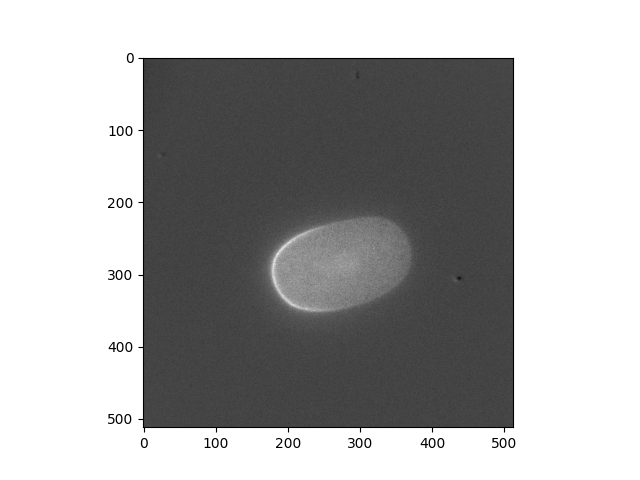

In [3]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')

### Initial ROI

Draw a preliminary ROI on the image using Roi_jupyter (or just load pre-defined ROI)

In [4]:
# r = ROI_jupyter(img, periodic=True, spline=True)
# r.run()

In [5]:
# np.savetxt('nwg338_ROI_manual.txt', r.roi)

In [6]:
roi = np.loadtxt('nwg338_ROI_manual.txt')

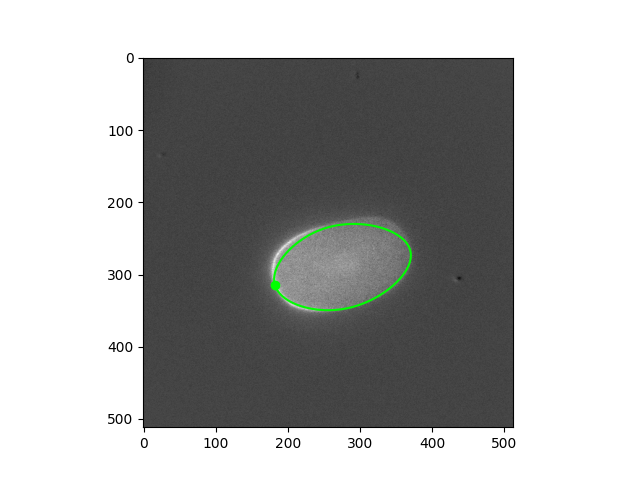

In [7]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.plot(roi[:, 0], roi[:, 1], c='lime')
ax.scatter(roi[0, 0], roi[0, 1], c='lime')

### Run quantification and segmentation

Segmentation and quantification is performed using the ImageQuant class

In [8]:
# Uncomment to see documentation:
# help(ImageQuant)  

__Set up class__. The underlying quantification model has a single parameter, sigma, which is related to the point spread function. By setting adaptive_sigma=True this parameter is trained on the image and does not need to be specified beforehand.

In [9]:
iq = ImageQuant(img=img, roi=roi, adaptive_sigma=True)

2024-05-17 10:55:59.372959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


__Run__. Running the algorithm will do the following:

1. The image will be straightened according to the inputted ROI
2. Gradient descent will be performed, in which a simulated image is optimised to match the true straightened image
3. Optimised parameters describing the cortex position in the simulated image are used to adjust the ROI, and the image is re-straightened
4. Gradient descent is repeated, and optimised parameters representing local cytoplasmic and membrane concentrations are saved

This cycle can be repeated by specifying the iterations parameter (default=2, indicating two cycles of straightening and gradient descent)

In [10]:
iq.run()

Iteration 1 of 2


100%|██████████| 400/400 [00:23<00:00, 16.86it/s]


Iteration 2 of 2


100%|██████████| 400/400 [00:27<00:00, 14.71it/s]


Time elapsed: 51.48 seconds 



### Sanity checks

Check the loss curve to make sure optimisation has stabilised:

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Descent step', ylabel='log10(Mean square error)'>)

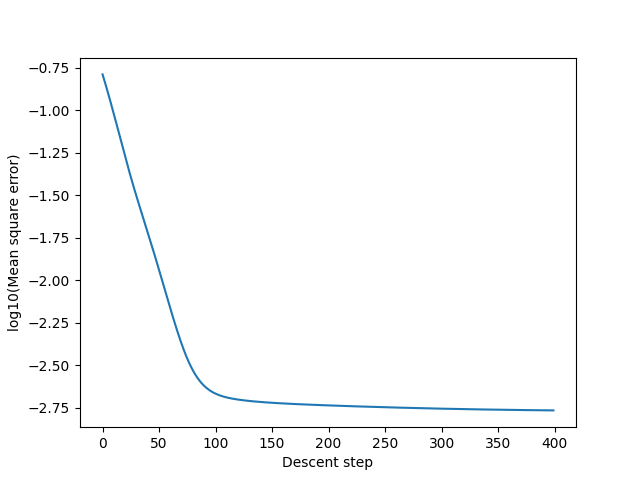

In [11]:
iq.plot_losses(log=True)

Plot fits to make sure they look appropriate (use slider to scroll along the image):

interactive(children=(FloatSlider(value=0.1, description='Position', max=1.0, step=0.01), Output()), _dom_clas…

(<Figure size 500x300 with 2 Axes>,
 (<Axes: xlabel='Position'>, <Axes: ylabel='Intensity'>))

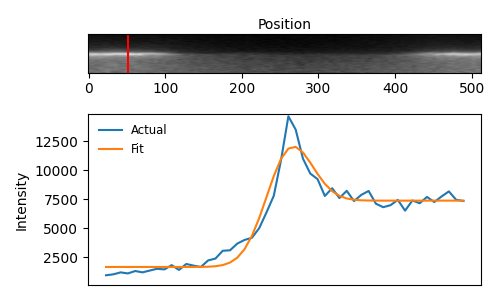

In [12]:
iq.plot_fits()

### Segmentation results

(<Figure size 400x400 with 1 Axes>, <Axes: >)

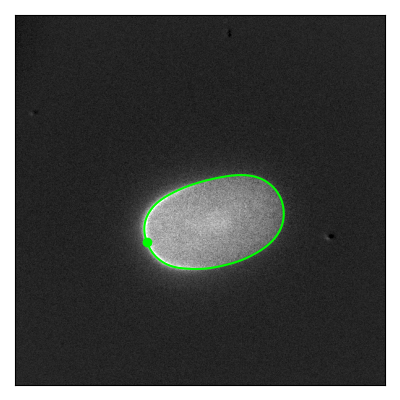

In [13]:
iq.plot_segmentation()

The new ROI can be accessed at iq.roi

### Quantification results

(<Figure size 500x300 with 1 Axes>,
 <Axes: xlabel='Position', ylabel='Membrane concentration'>)

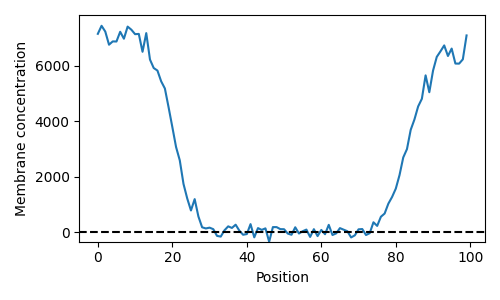

In [14]:
iq.plot_quantification()

Compile quantificiation results into a pandas dataframe. Here, you will see 100 positions which correspond to 100 evenly spaced points around the embryo circumference

In [15]:
quantification = iq.compile_res()
quantification

,Frame,Position,Membrane signal,Cytoplasmic signal
0,0,0,7153.342864,7069.257314
1,0,1,7442.520158,7133.951673
2,0,2,7233.980269,7023.270490
3,0,3,6761.498379,7322.593835
4,0,4,6880.149120,7363.919363
...,...,...,...,...
95,0,95,6622.204795,7125.605593
96,0,96,6083.119423,7246.611940
97,0,97,6079.926307,7489.863503
98,0,98,6234.648800,7353.277202


Note that these are in arbitrary units and do not give a direct measure of absolute protein concentrations (further calibrations would be required to convert to absolute concentrations). Similarly, cytoplasmic and membrane concentrations are in different units and should not be compared.

### Trained sigma value

In [16]:
print(iq.sigma)

3.1234538533889893


### Additional capabilities

__Fixed sigma__: If quantifying multiple images and comparing it's a good idea to use a fixed value of sigma (e.g. 2.5) so that quantification is consistant between images. This can be done with the following:

```python 
iq = ImageQuant(img=img, roi=roi, adaptive_sigma=False, sigma=...)
```

__Non-periodic ROI__: for example if you want to quantify only part of the cell rather than the whole circumference. In this case roi should be a non-periodic ROI (created using RoiJupyter with periodic=False).

```python 
iq = ImageQuant(img=img, roi=roi, periodic=False)
```

__Running multiple images in batch__: if quantifying multiple images, it can be much faster to quantify in batch. This can be done by inputting a list of images and a list of ROIs:

```python 
iq = ImageQuant(img=[img1, img2], roi=[roi1, roi2])
```

Alternatively a movie can be inputted as a 3D numpy array with a single ROI, and new ROIs will be found for each frame:

```python 
iq = ImageQuant(img=movie, roi=roi)
```

__Differential evolution method__: Fitting can alse be performed using a differential evolution algorithm (a global optimisation algorithm) rather than gradient descent:

```python 
iq = ImageQuant(img=movie, roi=roi, method='DE')
```